In [6]:
import pandas as pd
import numpy as np

In [7]:
# flip the columns and rows
df = pd.read_csv('gmonjv.csv', sep =';', skiprows=4)
df = df.transpose()
df.columns = df.iloc[0]
# drop top 2 rows
df.drop(df.index[0:2], inplace=True)
#df.set_index('Onderwerp', inplace=True)
df.dropna(axis=1, how='all', inplace=True)
# replace all commas with dots and turn to float
df = df.replace(',', '.', regex=True)
# replace values with only a dot with NaN
df = df.replace(r'^\.$', np.nan, regex=True)
# change dtype of cols to float
for col in df.columns:
    df[col] = df[col].astype(float)
# drop na cols
df.dropna(axis=1, how= 'any', inplace=True)
per_gem_vl = df

In [3]:
import cbsodata

# Search for all datasets related to Haaglanden and health
tables = cbsodata.get_table_list()
haaglanden_tables = [t for t in tables if 'jeugdhulp' in t['Title'].lower()]

for t in haaglanden_tables:
    print(f"{t['Identifier']} - {t['Title']}")


85096NED - Jeugdhulptrajecten in natura; verwijzer
85097NED - Jeugdhulptrajecten in natura; verwijzer, regio (gemeente)
82970NED - Jeugdhulptrajecten in natura; verwijzer, perspectief, 2015-2020
82971NED - Jeugdhulptrajecten in natura; verwijzer, regio (gemeente), 2015-2020


In [4]:
questionnaires = [83454,85990,82968,85097]
gemeentes = ['Delft', "'s-Gravenhage", "'s-Gravenhage (gemeente)", 'Den haag', 'Leidschendam-Voorburg', 'Midden-Delfland',
 'Pijnacker-Nootdorp', 'Rijswijk', 'Rijswijk (ZH.)', 'Wassenaar', 'Westland', 'Zoetermeer']

In [9]:
data = cbsodata.get_data(f'{questionnaires[0]}NED')
df = pd.DataFrame(data)
df = df[df.Regio.isin(gemeentes)].dropna()
kosten = df[(df['VormenVanJeugdzorg'] == 'JH 1 Totaal jeugdhulp') & (df['Perioden'] == '2023')]

In [ ]:
def remove_whitespace(df):
    columns = []
    for i, colname in enumerate(df.columns):
        indices = []
        for j in range(1, len(colname)):
            if (colname[j].isupper() and colname[j-1] != ' ') or (colname[j].isnumeric() and colname[j-1].isalpha()):
                indices.append(j)

                
        indices.append(None)
        columns.append((' ').join([colname[:indices[0]]]+[colname[indices[i]:indices[i+1]] for i in range(len(indices)-1)]))
    df.columns = columns

In [212]:
data = cbsodata.get_data(f'{questionnaires[1]}NED')
df = pd.DataFrame(data)


In [213]:
remove_whitespace(df)
df = df[df.Wijken.isin(gemeentes)].dropna(how='all')
df.columns = [(' ').join(x.split('_')[:-1]) if '_' in x else x for x in df.columns.tolist()]
df.columns = [x.split('k ')[1] if 'k ' in x else x for x in df.columns.tolist()]
df = df[df['Vormen'] == 'Totaal jeugdhulp in natura']
basis = pd.DataFrame({'Wijken': df['Wijken'], 'Jongeren': df['Totaal Jongeren Met Jeugdzorg In Natura'], 'Trajecten': df['Totaal Trajecten In Natura']})

for col in ['Gemeentenaam', 'Soort Regio', 'Indelingswijziging Wijken', 'I D', 'Wijken', 'Vormen', 'Perioden']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)
leeftijd = pd.concat([basis[['Wijken', 'Jongeren']], df.iloc[:, 1:5]], axis=1)
huishouden = pd.concat([basis[['Wijken', 'Jongeren']], df.iloc[:, 5:8]], axis=1)
verwijzers = pd.concat([basis[['Wijken', 'Trajecten']], df.iloc[:, 9:17]], axis=1)


In [216]:
huishouden.columns

Index(['Wijken', 'Jongeren', 'Thuiswonend Kind In Eenouderhuishouden',
       'Thuiswonend Kind Bij Een Paar', 'Ander Huishouden'],
      dtype='object')

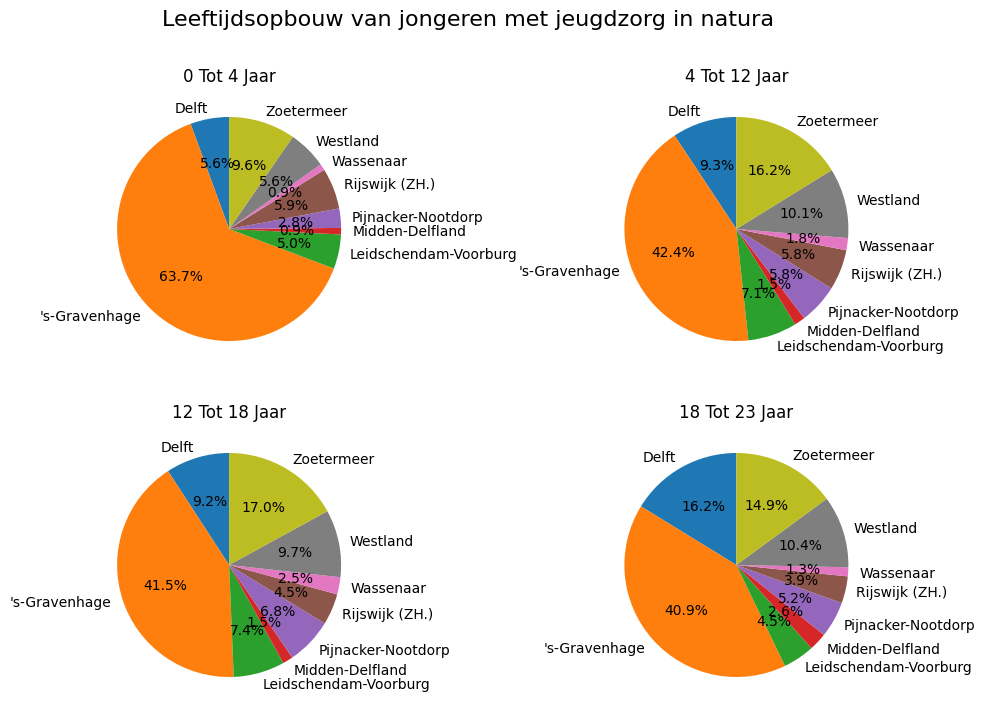

In [217]:
def create_pie_chart(df, cols, group_col, title, ):
    import matplotlib.pyplot as plt
    graph_count = len(cols)
    # set up a subplot for the age categories in leeftijd, create piecharts for each
    if graph_count% 3 == 0:
        fig, axs = plt.subplots(graph_count//3, 3, figsize=(12, 8))
    elif graph_count % 2 == 0:
        fig, axs = plt.subplots(graph_count//2, 2, figsize=(12, 8))
    else:
        fig, axs = plt.subplots(graph_count, 1, figsize=(12, 8))
    axs = axs.flatten()
    # create pie charts for each age category
    # total title
    fig.suptitle(title, fontsize=16)
    for i, col in enumerate(cols, start=0):
        # create pie chart for each age category
        axs[i].pie(leeftijd[col], labels=df[group_col], autopct='%1.1f%%', startangle=90)
        axs[i].set_title(col)

create_pie_chart(leeftijd, leeftijd.columns[2:], 'Wijken', 'Leeftijdsopbouw van jongeren met jeugdzorg in natura')
#create_pie_chart(huishouden, huishouden.columns[2:], 'Wijken', 'Huishoudens met jeugdzorg in natura')

In [60]:
df.columns[1:5]

Index(['0Tot4Jaar', '4Tot12Jaar', '12Tot18Jaar', '18Tot23Jaar'], dtype='object')

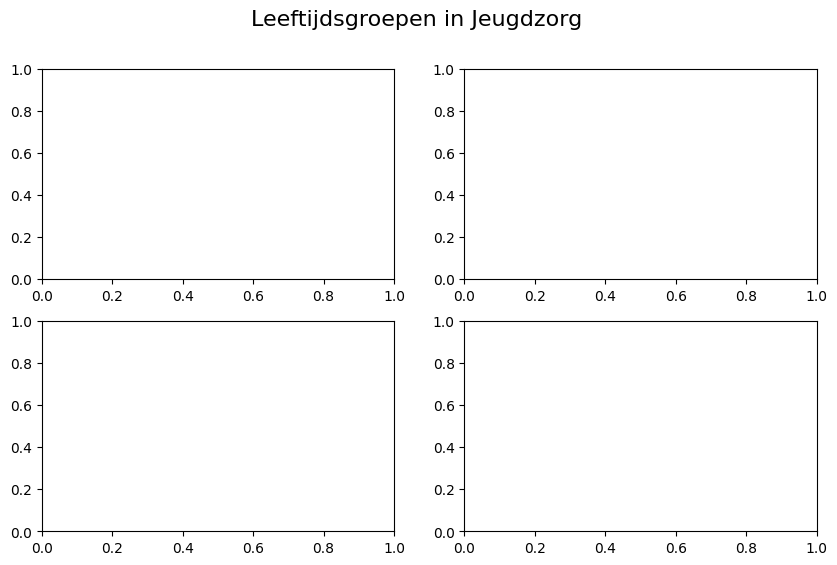

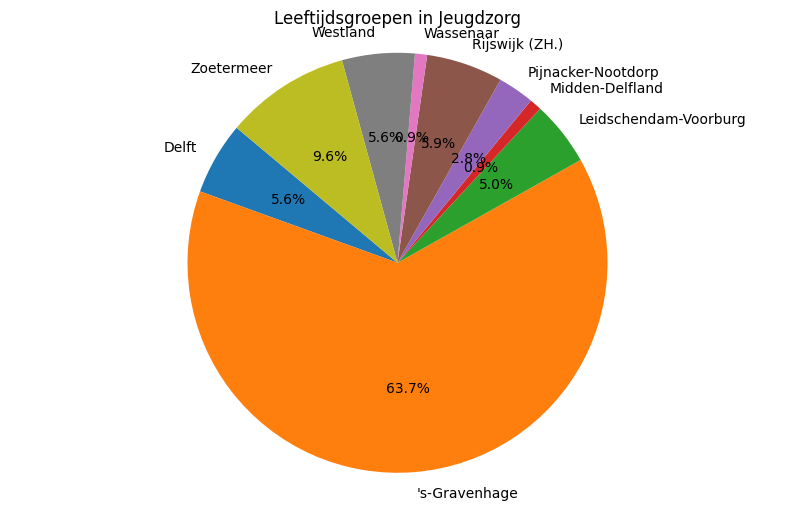

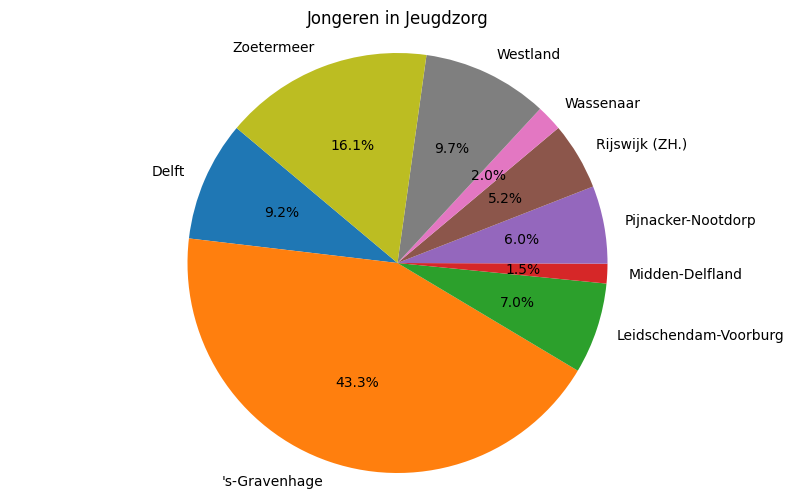

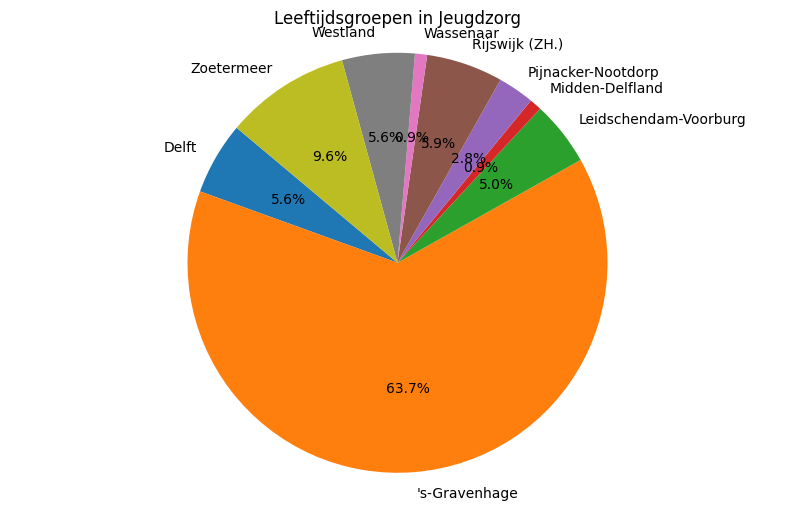

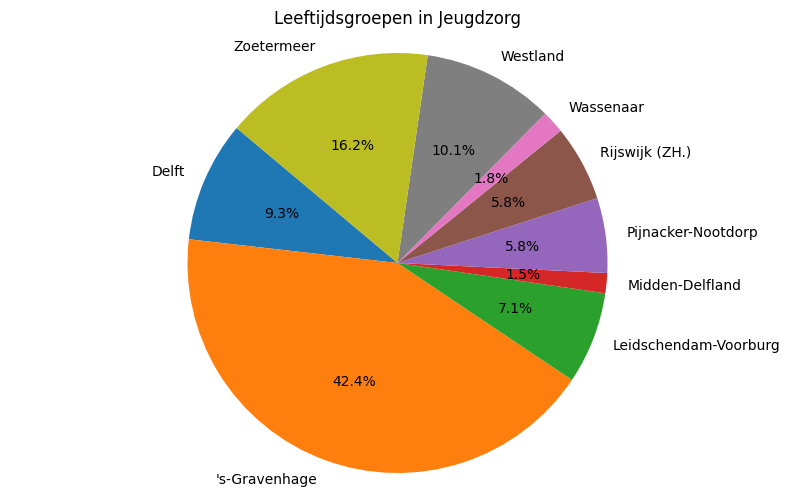

In [48]:
# plot leeftijd as a pie diagram
import matplotlib.pyplot as plt

def setup_subplots(plot_count, title):

    if plot_count % 3 == 0:
        fig, axs = plt.subplots(plot_count//3, 3, figsize=(10, 6))
    elif plot_count % 2 == 0:
        fig, axs = plt.subplots(plot_count//2, 2, figsize=(10, 6))
    else:
        fig, axs = plt.subplots(plot_count, 1, figsize=(10, 6))
    fig.suptitle(title, fontsize=16)
    return fig, axs

fig, axs = setup_subplots(4, 'Leeftijdsgroepen in Jeugdzorg')  

axs[0,1] = plot_pie(leeftijd, 'Leeftijdsgroepen in Jeugdzorg', '0Tot4Jaar')
plot_pie(leeftijd, 'Jongeren in Jeugdzorg', 'Jongeren')
plot_pie(leeftijd, 'Leeftijdsgroepen in Jeugdzorg', '0Tot4Jaar')
plot_pie(leeftijd, 'Leeftijdsgroepen in Jeugdzorg', '4Tot12Jaar')

In [449]:
data = cbsodata.get_data(f'{questionnaires[3]}NED')
df = pd.DataFrame(data)


In [466]:
df = df[df['VerwijzerJeugdzorg'] == 'Totaal verwijzer']
df = df[df['Perioden'].str.contains('2024')]
df = df[df['RegioS'].isin(gemeentes)]
df[df.columns[df.columns.str.contains('TotaalBeg')]]


,TotaalBegonnenTrajecten_2,TotaalBegonnenTrajecten_24,TotaalBegonnenTrajecten_46,TotaalBegonnenTrajecten_68,TotaalBegonnenTrajecten_90
1229,965.0,900.0,110.0,790.0,60.0
1659,4970.0,4735.0,1680.0,3050.0,240.0
2279,680.0,655.0,NaN,645.0,30.0
2479,160.0,150.0,NaN,150.0,10.0
2929,510.0,495.0,NaN,495.0,15.0
3049,565.0,545.0,NaN,540.0,20.0
3769,205.0,200.0,NaN,200.0,NaN
3869,920.0,885.0,NaN,880.0,40.0
4059,1415.0,1365.0,10.0,1355.0,55.0


In [435]:
cols = df.columns
for col in cols:
    print(col)
    print(df[col].unique())
    print()
#df.describe()

ID
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]

VerwijzerJeugdzorg
['Totaal verwijzer' 'Gemeentelijke toegang' 'Huisarts' 'Jeugdarts'
 'Gecertificeerde instelling' 'Medisch specialist'
 'Rechter, Officier van Justitie, ...' 'Geen verwijzer'
 'Verwijzer onbekend']

Perioden
['1e halfjaar 2021' '2e halfjaar 2021' '2021' '1e halfjaar 2022'
 '2e halfjaar 2022' '2022' '1e halfjaar 2023' '2e halfjaar 2023' '2023'
 '1e half jaar 2024']

TotaalJeugdhulptrajectenInNatura_1
[516745 513965 652970 525680 535270 667420 556090 557690 702100 522390
 165730 168325 208430 173350 178020 217895 184795 187425 231155 178730
 180740 179910 231425 183125 186430 235545 194125 193020 247100 181165
  13680  14400  17860  15130  16180  20020  16940  17820  22225  17330
  49295  48730  

In [ ]:
data.columns = [(' ').join(x.split('_')[:-1]) for x in data.columns.tolist()]
data.drop(data.columns[0], axis=1, inplace=True)
data['Gemeentenaam'] = data['Gemeentenaam'].apply(lambda x: x.strip())
data.head(5)

In [ ]:
haaglanden = data[data['Gemeentenaam'].isin(gemeentes)]

In [358]:
haaglanden.isna().sum().sort_values(ascending=False).head(10)

PercentageWoningenMetStadsverwarming    468
VrijstaandeWoning                       246
VrijstaandeWoning                       243
TweeOnderEenKapWoning                   234
TweeOnderEenKapWoning                   232
Hoekwoning                              132
Appartement                             128
Hoekwoning                              126
Appartement                             121
Dekkingspercentage                      116
dtype: int64